### OmniXAI in a ML workflow

This tutorial shows how to apply OmniXAI in different stages in a standard ML workflow.

In [1]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

The dataset used in this example is for income prediction (https://archive.ics.uci.edu/ml/datasets/adult).

In [2]:
import os
import numpy as np
import pandas as pd

# Load the dataset
feature_names = [
    "Age", "Workclass", "fnlwgt", "Education",
    "Education-Num", "Marital Status", "Occupation",
    "Relationship", "Race", "Sex", "Capital Gain",
    "Capital Loss", "Hours per week", "Country", "label"
]
df = pd.DataFrame(
    np.genfromtxt(os.path.join('data', 'adult.data'), delimiter=', ', dtype=str),
    columns=feature_names
)
print(df)

      Age         Workclass  fnlwgt   Education Education-Num  \
0      39         State-gov   77516   Bachelors            13   
1      50  Self-emp-not-inc   83311   Bachelors            13   
2      38           Private  215646     HS-grad             9   
3      53           Private  234721        11th             7   
4      28           Private  338409   Bachelors            13   
...    ..               ...     ...         ...           ...   
32556  27           Private  257302  Assoc-acdm            12   
32557  40           Private  154374     HS-grad             9   
32558  58           Private  151910     HS-grad             9   
32559  22           Private  201490     HS-grad             9   
32560  52      Self-emp-inc  287927     HS-grad             9   

           Marital Status         Occupation   Relationship   Race     Sex  \
0           Never-married       Adm-clerical  Not-in-family  White    Male   
1      Married-civ-spouse    Exec-managerial        Husband  Wh

Let's first check if some features are correlated and if there exists data imbalance issues that leads potential sociological bias. We can create an `DataAnalyzer` explainer to do this task.

Correlation:


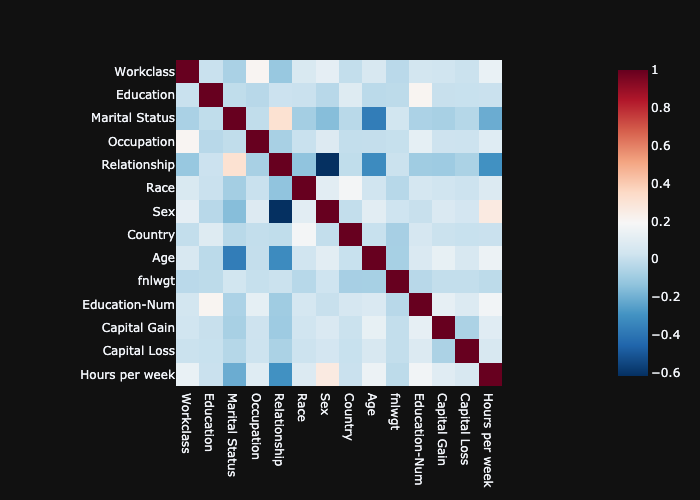

Imbalance#0:


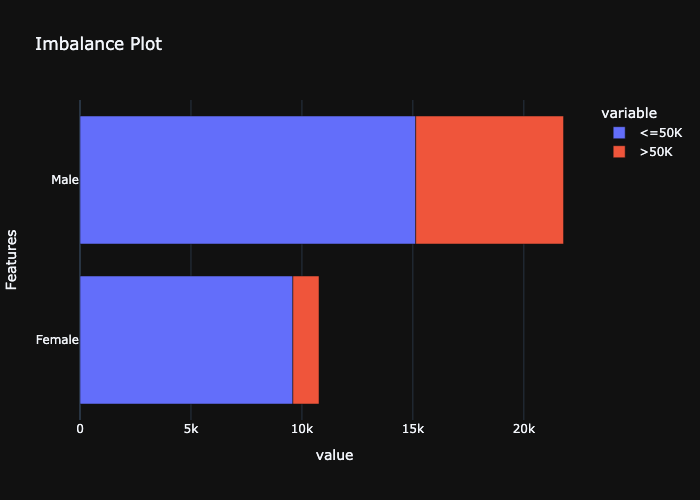

Imbalance#1:


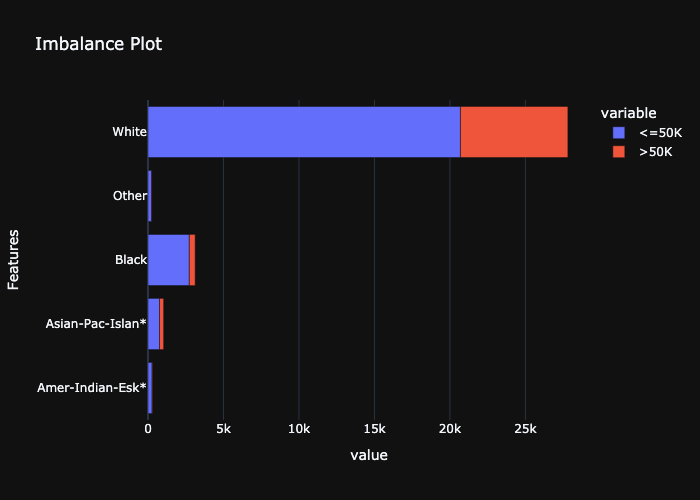

Imbalance#1:


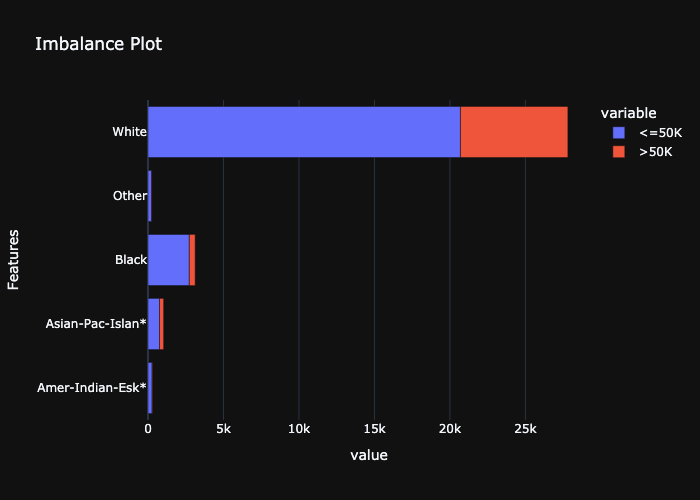

In [3]:
from omnixai.data.tabular import Tabular
from omnixai.explainers.data import DataAnalyzer

tabular_data = Tabular(
    df,
    categorical_columns=['Workclass', 'Education', 'Marital Status', 
                         'Occupation', 'Relationship', 'Race', 'Sex', 'Country'],
    target_column='label'
)

# Initialize a `DataAnalyzer` explainer.
# We can choose multiple explainers/analyzers by specifying analyzer names. 
# In this example, the first explainer is for feature correlation analysis and 
# the others are for feature imbalance analysis (the same explainer with different parameters).
explainer = DataAnalyzer(
    explainers=["correlation", "imbalance#0", "imbalance#1", "imbalance#2"],
    mode="classification",
    data=tabular_data
)
# Generate explanations by calling `explain_global`.
explanations = explainer.explain_global(
    params={"imbalance#0": {"features": ["Sex"]},
            "imbalance#1": {"features": ["Race"]},
            "imbalance#2": {"features": ["Sex", "Race"]}}
)

print("Correlation:")
explanations["correlation"].ipython_plot()
print("Imbalance#0:")
explanations["imbalance#0"].ipython_plot()
print("Imbalance#1:")
explanations["imbalance#1"].ipython_plot()
print("Imbalance#1:")
explanations["imbalance#1"].ipython_plot()

From the correlation plot we can observe that "Relationship" has strong correlations with "Matrital Status" and "Sex", so we may remove this feature. From the data imbalance plots we can see that the class labels are highly imbalanced among different "Sex" and "Race". Therefore, we must ignore these features when building a machine learning model to avoid sociological bias.

In [4]:
df = df.drop(columns=["Sex", "Race", "Relationship"])
print(df)

      Age         Workclass  fnlwgt   Education Education-Num  \
0      39         State-gov   77516   Bachelors            13   
1      50  Self-emp-not-inc   83311   Bachelors            13   
2      38           Private  215646     HS-grad             9   
3      53           Private  234721        11th             7   
4      28           Private  338409   Bachelors            13   
...    ..               ...     ...         ...           ...   
32556  27           Private  257302  Assoc-acdm            12   
32557  40           Private  154374     HS-grad             9   
32558  58           Private  151910     HS-grad             9   
32559  22           Private  201490     HS-grad             9   
32560  52      Self-emp-inc  287927     HS-grad             9   

           Marital Status         Occupation Capital Gain Capital Loss  \
0           Never-married       Adm-clerical         2174            0   
1      Married-civ-spouse    Exec-managerial            0            0 

In the next step, we do a rough feature selection by analyzing the information gain and chi-squared stats between features and targets.

Mutual information:


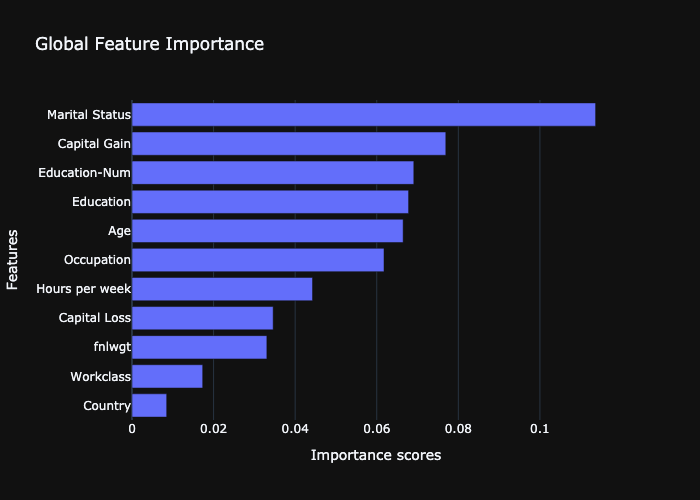

Chi square:


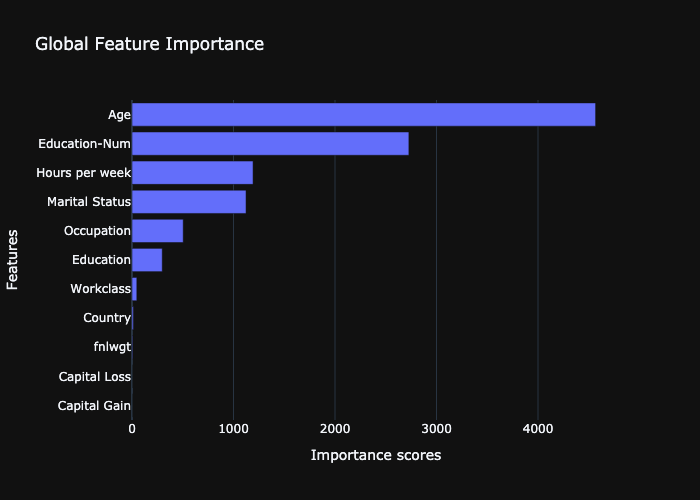

In [5]:
tabular_data = Tabular(
    df,
    categorical_columns=['Workclass', 'Education', 'Marital Status', 'Occupation', 'Country'],
    target_column='label'
)
explainer = DataAnalyzer(
    explainers=["mutual", "chi2"],
    mode="classification",
    data=tabular_data
)
data_explanations = explainer.explain_global()

print("Mutual information:")
data_explanations["mutual"].ipython_plot()
print("Chi square:")
data_explanations["chi2"].ipython_plot()

Clearly, the most important features showed above are "Age", "Marital Statues", "Eduction-Num", "Hours per week", "Occupation" and "Education". "Capital Gain" is not consistent among these two methods, while "Workclass", "Capital Loss", "fnlwgt", and "Country" are the least important features, so we may consider to remove them or do further analysis.

In [6]:
# We drop these three features because they have relatively low importance scores.
tabular_data = Tabular(
    df.drop(columns=["Capital Loss", "fnlwgt", "Country"]),
    categorical_columns=['Workclass', 'Education', 'Marital Status', 'Occupation'],
    target_column='label'
)
print(tabular_data)

      Age         Workclass   Education Education-Num      Marital Status  \
0      39         State-gov   Bachelors            13       Never-married   
1      50  Self-emp-not-inc   Bachelors            13  Married-civ-spouse   
2      38           Private     HS-grad             9            Divorced   
3      53           Private        11th             7  Married-civ-spouse   
4      28           Private   Bachelors            13  Married-civ-spouse   
...    ..               ...         ...           ...                 ...   
32556  27           Private  Assoc-acdm            12  Married-civ-spouse   
32557  40           Private     HS-grad             9  Married-civ-spouse   
32558  58           Private     HS-grad             9             Widowed   
32559  22           Private     HS-grad             9       Never-married   
32560  52      Self-emp-inc     HS-grad             9  Married-civ-spouse   

              Occupation Capital Gain Hours per week  label  
0           A

We now train a XGBoost classifier for this task.

In [7]:
import sklearn
import xgboost
from omnixai.preprocessing.tabular import TabularTransform

np.random.seed(12345)
# Train an XGBoost model
transformer = TabularTransform().fit(tabular_data)
x = transformer.transform(tabular_data)
train, test, train_labels, test_labels = \
    sklearn.model_selection.train_test_split(x[:, :-1], x[:, -1], train_size=0.80)
print('Training data shape: {}'.format(train.shape))
print('Test data shape:     {}'.format(test.shape))

class_names = transformer.class_names
gbtree = xgboost.XGBClassifier(n_estimators=300, max_depth=5)
gbtree.fit(train, train_labels)
print('Test accuracy: {}'.format(
    sklearn.metrics.accuracy_score(test_labels, gbtree.predict(test))))

# Convert the transformed data back to Tabular instances
train_data = transformer.invert(train)
test_data = transformer.invert(test)

Training data shape: (26048, 51)
Test data shape:     (6513, 51)
Test accuracy: 0.8567480423767849


We then create an `TabularExplainer` explainer to generate local and global explanations.

In [8]:
from omnixai.explainers.tabular import TabularExplainer

# Initialize a TabularExplainer
explainers = TabularExplainer(
    explainers=["lime", "shap", "mace", "pdp", "ale"],
    mode="classification",
    data=train_data,
    model=gbtree,
    preprocess=lambda z: transformer.transform(z),
    params={
        "lime": {"kernel_width": 3},
        "shap": {"nsamples": 100},
        "mace": {"ignored_features": ["Marital Status"]}
    }
)

/Users/thewelcomer/Coding/CV-IS-Fall-2024/OmniXAI/omnixai/explainers/tabular/agnostic/ale.py:114: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.22289693890241088' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/Users/thewelcomer/Coding/CV-IS-Fall-2024/OmniXAI/omnixai/explainers/tabular/agnostic/ale.py:114: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3018273834578554' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/Users/thewelcomer/Coding/CV-IS-Fall-2024/OmniXAI/omnixai/explainers/tabular/agnostic/ale.py:114: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5072959416324669' has dtype incompatible with int64, please explicitly cast to a compatible dtype

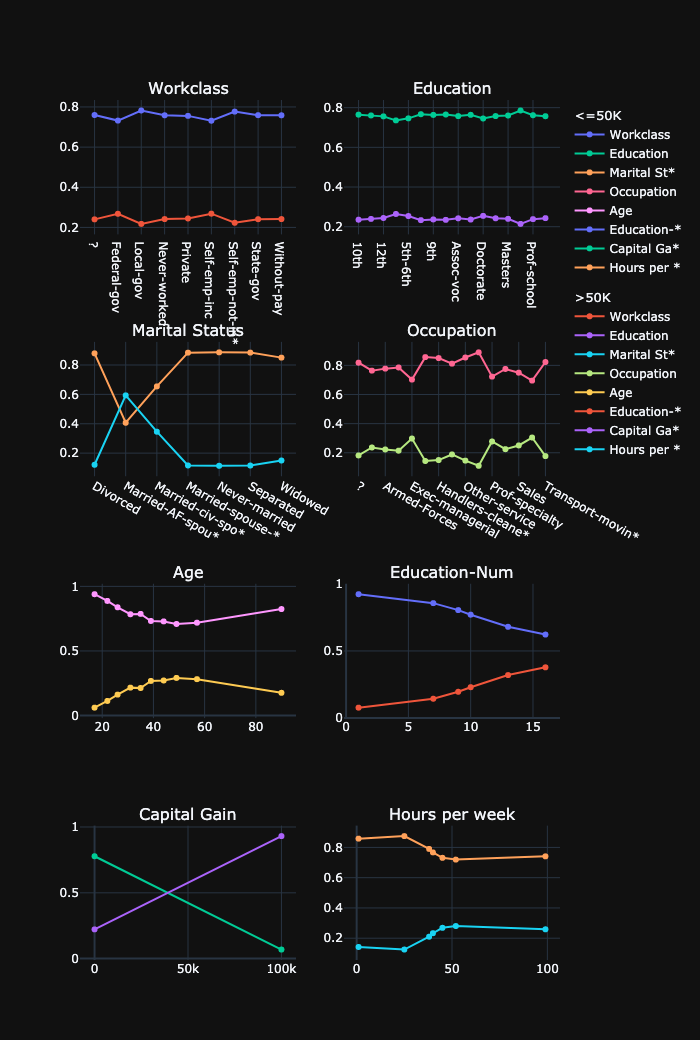

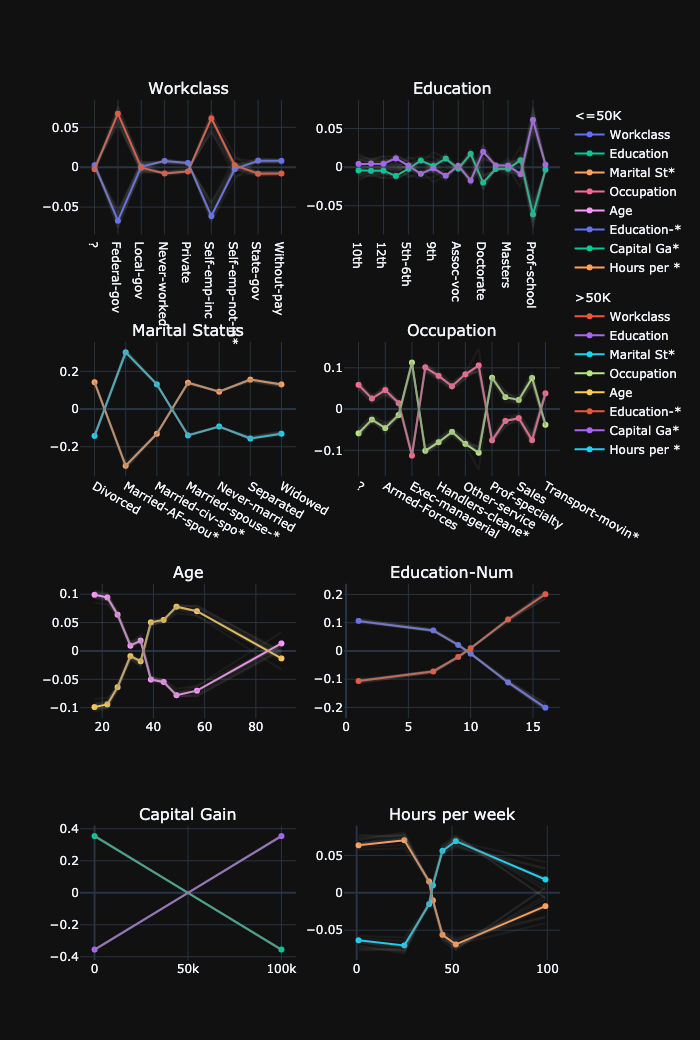

In [9]:
# Generate global explanations
global_explanations = explainers.explain_global()
global_explanations["pdp"].ipython_plot(class_names=class_names)
global_explanations["ale"].ipython_plot(class_names=class_names)

The global explanations generated by PDP describe the general behavior of this classifier. For example, the income increases when "Age" increases from 20 to 50 and then decreases a bit after 50. A large number of educations or a longer working time implies a higher income for the model prediction. But note that these results only show how a model makes predictions but don't show causal relationships between each feature and the income, e.g., whether a longer working time is the cause of a higher income or a higher income is the cause of more working hours is unclear.

For some specific test instances, we can generate local explanations to analyze the predictions.

  0%|          | 0/5 [00:00<?, ?it/s]

LIME results:


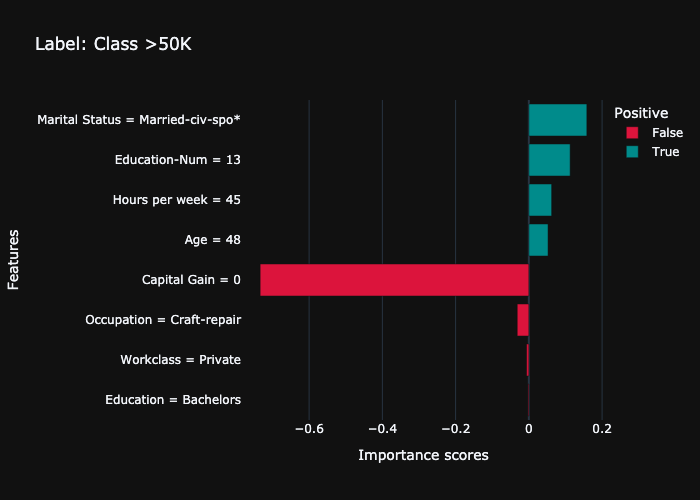

SHAP results:


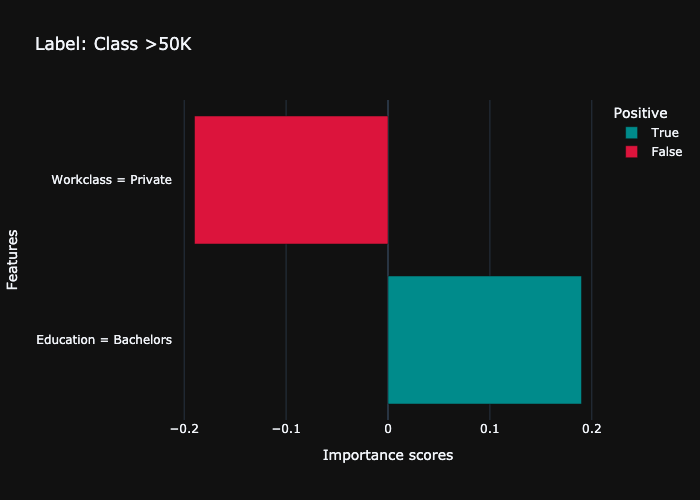

MACE results:


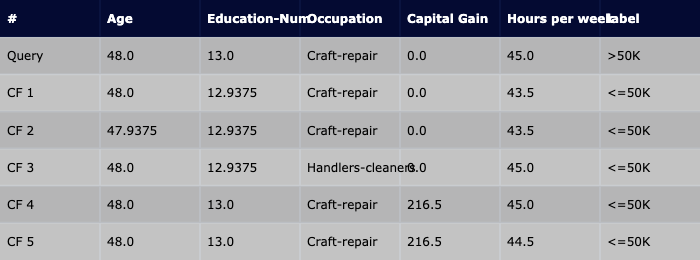

In [10]:
# Generate local explanations
test_instances = test_data[1653:1658]
local_explanations = explainers.explain(X=test_instances)

index = 0
print("LIME results:")
local_explanations["lime"].ipython_plot(index, class_names=class_names)
print("SHAP results:")
local_explanations["shap"].ipython_plot(index, class_names=class_names)
print("MACE results:")
local_explanations["mace"].ipython_plot(index, class_names=class_names)

The results of LIME and SHAP show the feature importance scores for this prediction (the predicted label is > 50k), e.g., the positive features (features making income > 50k) are "Marital Status", "Education-Num", "Age" and "Hours per week", the negative features are "Capital Gain" and "Ocupation". MACE generates several counterfactual examples, e.g., if "Education-Num" is 12 instead of 13 ("Education-Num" decreases) or "Hours per week" decreases to 40, the predicted label will become ">= 50k".

We we create a `PredictionAnalyzer` for computing performance metrics for this task:

In [11]:
# Compute metrics
from omnixai.explainers.prediction import PredictionAnalyzer

analyzer = PredictionAnalyzer(
    mode="classification",
    test_data=test_data,
    test_targets=test_labels,
    model=gbtree,
    preprocess=lambda z: transformer.transform(z)
)
prediction_explanations = analyzer.explain()

metric:


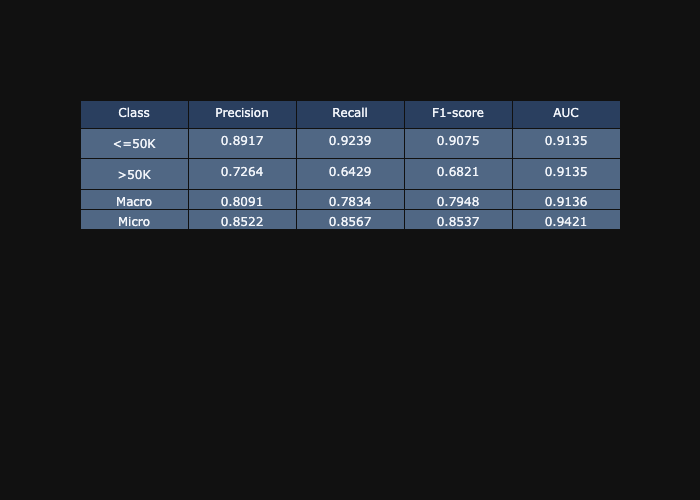

confusion_matrix:


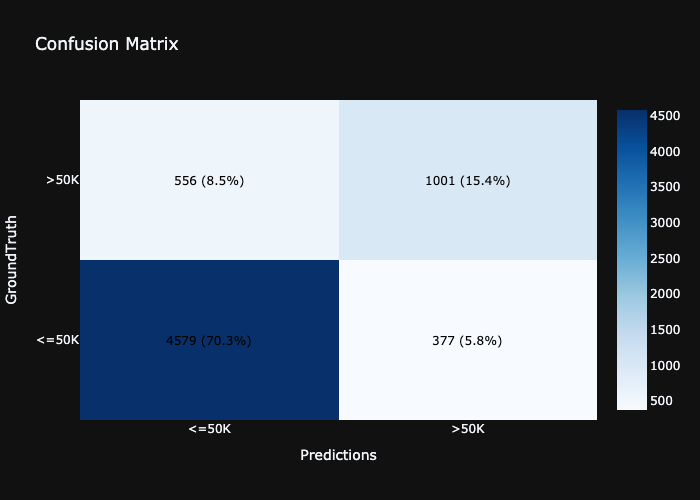

roc:


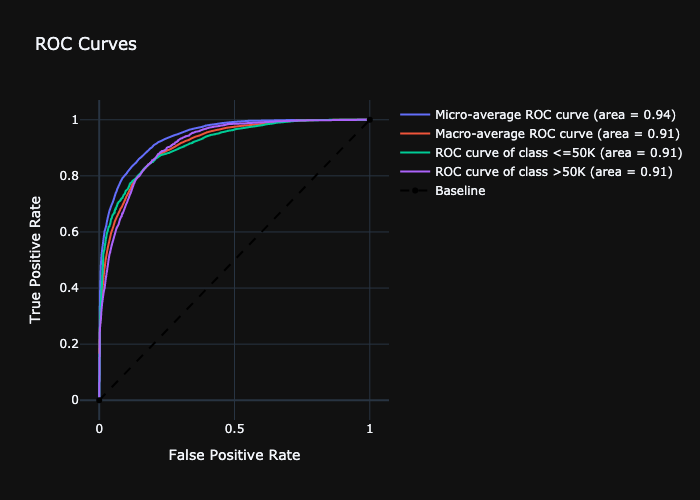

precision_recall:


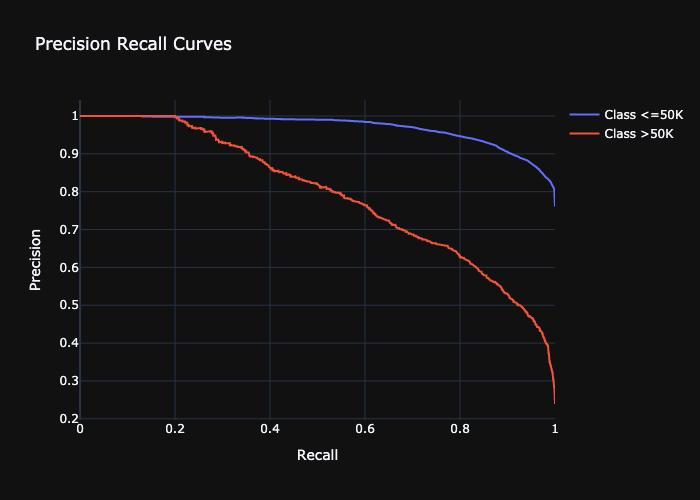

cumulative_gain:


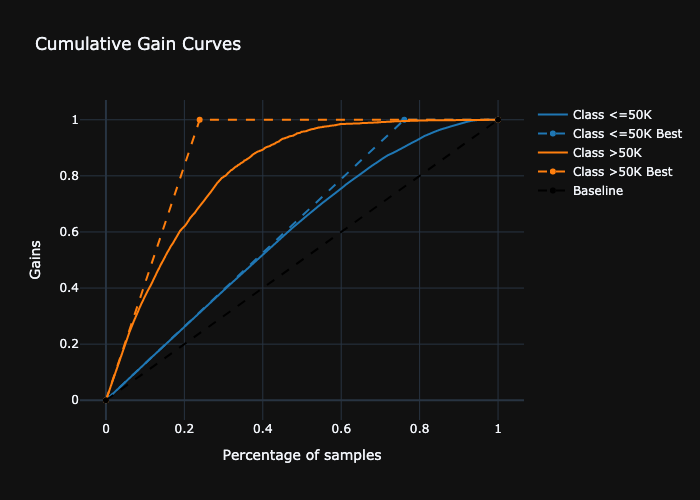

lift_curve:


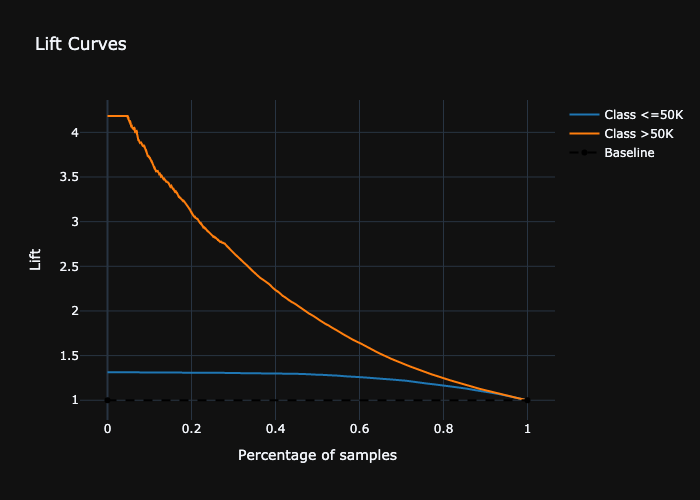

In [12]:
for name, metrics in prediction_explanations.items():
    print(f"{name}:")
    metrics.ipython_plot(class_names=class_names)

We can launch a dashboard to examine all the explanations:

In [13]:
from omnixai.visualization.dashboard import Dashboard

# Launch a dashboard for visualization
dashboard = Dashboard(
    instances=test_instances,
    data_explanations=data_explanations,
    local_explanations=local_explanations,
    global_explanations=global_explanations,
    prediction_explanations=prediction_explanations,
    class_names=class_names
)
dashboard.show()

ModuleNotFoundError: No module named 'dash'